# COCO annotations (.json) -> YOLO segment annotations (.txt)

## Requirements
* Download COCO annotations file (https://cocodataset.org/#download)
* Install python libraries in your own environment.

In [ ]:
"""
@Author: jw.kang
@Date: 2024-01-15
@Modified: 2024-01-15
"""

### Requirements
'''
pycocotools
tqdm
numpy
opencv-python
scikit-image
'''

## 1. Basic Tutorial
We will use pycocotools for data preprocessing.

In [1]:
'''Load dataset'''
from pycocotools.coco import COCO

coco = COCO('./annotations/instances_val2017.json')

loading annotations into memory...
Done (t=0.38s)
creating index...
index created!


In [2]:
category_ids = coco.getCatIds(catNms=['person'])

# COCO datasets class id starts to 1. not 0.
print('Category id:',category_ids)

Category id: [1]


In [3]:
# Get image ids
image_ids = coco.getImgIds()
print('Image IDs length:',len(image_ids))
print('Sample image ID:',image_ids[0])

Image IDs length: 5000
Sample image ID: 397133


In [4]:
coco.loadImgs(image_ids[0])

[{'license': 4,
  'file_name': '000000397133.jpg',
  'coco_url': 'http://images.cocodataset.org/val2017/000000397133.jpg',
  'height': 427,
  'width': 640,
  'date_captured': '2013-11-14 17:02:52',
  'flickr_url': 'http://farm7.staticflickr.com/6116/6255196340_da26cf2c9e_z.jpg',
  'id': 397133}]

In [5]:
# annotations = coco.getAnnIds(catIds=category_ids, iscrowd=False)  # corresponding specific class
annotations = coco.getAnnIds(catIds=coco.getCatIds(), iscrowd=False)  # all class

In [6]:
len(annotations)

36335

In [7]:
# View all class_ids
print(coco.getCatIds())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90]


## 2. Visualization

In [8]:
# View sample image and annotations

from pycocotools.coco import COCO
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

coco_annotation_path = './annotations/instances_val2017.json'
img_folder = './val2017'
output_folder = './segmentation_visualization/'

coco = COCO(coco_annotation_path)
image_ids = coco.getImgIds()

def random_imshow(coco_image_ids):
    # Load image information
    n = np.random.randint(0,len(coco_image_ids))
    image_id = coco_image_ids[n]
    img_info = coco.loadImgs(image_id)[0]
    file_name = img_info['file_name']

    # Load image
    img_path = os.path.join(img_folder, file_name)
    img = cv2.imread(img_path)

    plt.figure(figsize=(8,8))
    plt.axis('off')
    plt.imshow(img)
  
    ann_ids = coco.getAnnIds(imgIds=image_id, iscrowd=False)
    annotations = coco.loadAnns(ann_ids)
    img2 = coco.showAnns(annotations)

    plt.axis('off')
    plt.show()
    


loading annotations into memory...
Done (t=0.41s)
creating index...
index created!


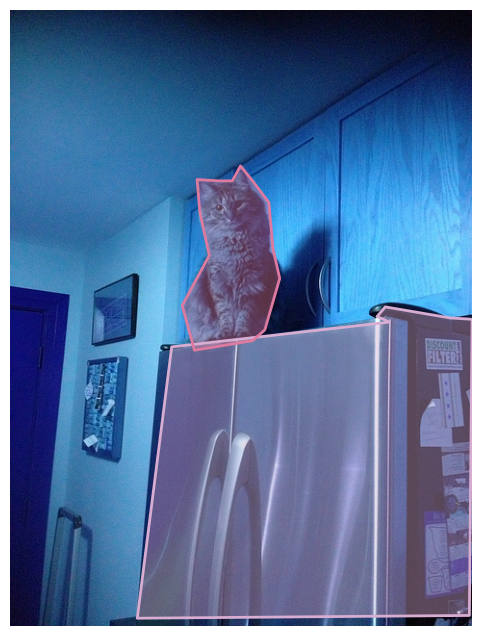

In [9]:
random_imshow(image_ids)

## 3. Convert annotations.json to yolo txt labels

### 3.1 json -> txt

In [10]:
from pycocotools.coco import COCO
import os

def convert_segmentation_to_relative(segmentation, img_width, img_height):
    # Convert segmentation to list of x, y coordinates
    x_y_pairs = [(segmentation[i], segmentation[i + 1]) for i in range(0, len(segmentation), 2)]

    # Convert absolute coordinates to relative coordinates (0 to 1)
    relative_coordinates = [(round(x / img_width, 3), round(y / img_height, 3)) for x, y in x_y_pairs]

    # Flatten the list of tuples to a single list
    flat_relative_coordinates = [coord for pair in relative_coordinates for coord in pair]

    return flat_relative_coordinates


def convert_coco_segmentation_to_yolo(coco_annotation_path, output_folder):
    # Load COCO annotations
    coco = COCO(coco_annotation_path)

    # Get all image IDs
    image_ids = coco.getImgIds()

    for img_id in image_ids:
        # Load image information
        img_info = coco.loadImgs(img_id)[0]
        file_name = img_info['file_name']
        img_width = img_info['width']
        img_height = img_info['height']
        
        # Get annotation IDs for the current image
        ann_ids = coco.getAnnIds(imgIds=img_id, iscrowd=False)
        annotations = coco.loadAnns(ann_ids)

        # Create YOLO format content
        yolo_content = ""
        for ann in annotations:
            # Extract polygon coordinates
            segmentation = convert_segmentation_to_relative(ann['segmentation'][0], img_width, img_height)
            polygon_points = [str(coord) for coord in segmentation]

            # YOLO format: class x1 y1 x2 y2 ... xn yn
            yolo_line = f"{ann['category_id']-1} {' '.join(polygon_points)}\n"  # class id - 1 (to adjust person class 1 to 0)
            yolo_content += yolo_line

        # Save YOLO format content to a text file
        output_txt_path = os.path.join(output_folder, os.path.splitext(file_name)[0] + '.txt')
        with open(output_txt_path, 'w') as txt_file:
            txt_file.write(yolo_content)

In [11]:
# Run code
coco_annotation_path = './annotations/instances_val2017.json'  # change train2017 and try
output_folder = './instances_val_labels/'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

convert_coco_segmentation_to_yolo(coco_annotation_path, output_folder)

loading annotations into memory...
Done (t=0.41s)
creating index...
index created!


### 3.2 90 classes -> 80 classes

In [12]:
'''
The string below can be obtained from coco128-seg.yaml.
'''

class_80_str = """
  0: person
  1: bicycle
  2: car
  3: motorcycle
  4: airplane
  5: bus
  6: train
  7: truck
  8: boat
  9: traffic light
  10: fire hydrant
  11: stop sign
  12: parking meter
  13: bench
  14: bird
  15: cat
  16: dog
  17: horse
  18: sheep
  19: cow
  20: elephant
  21: bear
  22: zebra
  23: giraffe
  24: backpack
  25: umbrella
  26: handbag
  27: tie
  28: suitcase
  29: frisbee
  30: skis
  31: snowboard
  32: sports ball
  33: kite
  34: baseball bat
  35: baseball glove
  36: skateboard
  37: surfboard
  38: tennis racket
  39: bottle
  40: wine glass
  41: cup
  42: fork
  43: knife
  44: spoon
  45: bowl
  46: banana
  47: apple
  48: sandwich
  49: orange
  50: broccoli
  51: carrot
  52: hot dog
  53: pizza
  54: donut
  55: cake
  56: chair
  57: couch
  58: potted plant
  59: bed
  60: dining table
  61: toilet
  62: tv
  63: laptop
  64: mouse
  65: remote
  66: keyboard
  67: cell phone
  68: microwave
  69: oven
  70: toaster
  71: sink
  72: refrigerator
  73: book
  74: clock
  75: vase
  76: scissors
  77: teddy bear
  78: hair drier
  79: toothbrush
"""

In [13]:
# COCO dataset annotation file path
coco_annotation_path = './annotations/instances_val2017.json'

# Create COCO instance
coco = COCO(coco_annotation_path)

# Mapping class name
class_mapping = {}
for cat_id, cat_info in coco.cats.items():
    class_mapping[cat_id] = cat_info['name']

# Convert format
dict_90_classes = {int(k): v for k, v in class_mapping.items()}

print("names:")
for k, v in dict_90_classes.items():
    print(f"  {k}: {v}")

loading annotations into memory...
Done (t=0.41s)
creating index...
index created!
names:
  1: person
  2: bicycle
  3: car
  4: motorcycle
  5: airplane
  6: bus
  7: train
  8: truck
  9: boat
  10: traffic light
  11: fire hydrant
  13: stop sign
  14: parking meter
  15: bench
  16: bird
  17: cat
  18: dog
  19: horse
  20: sheep
  21: cow
  22: elephant
  23: bear
  24: zebra
  25: giraffe
  27: backpack
  28: umbrella
  31: handbag
  32: tie
  33: suitcase
  34: frisbee
  35: skis
  36: snowboard
  37: sports ball
  38: kite
  39: baseball bat
  40: baseball glove
  41: skateboard
  42: surfboard
  43: tennis racket
  44: bottle
  46: wine glass
  47: cup
  48: fork
  49: knife
  50: spoon
  51: bowl
  52: banana
  53: apple
  54: sandwich
  55: orange
  56: broccoli
  57: carrot
  58: hot dog
  59: pizza
  60: donut
  61: cake
  62: chair
  63: couch
  64: potted plant
  65: bed
  67: dining table
  70: toilet
  72: tv
  73: laptop
  74: mouse
  75: remote
  76: keyboard
  77: 

In [14]:
lines = class_80_str.strip().split('\n')

# Create a dictionary by extracting the class number and name from each line.
dict_80_classes = {int(line.split(':')[0].strip()): line.split(':')[1].strip() for line in lines}

print(dict_80_classes)

{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microw

In [15]:
result_dict = {}

# Compare 2 dicts and matching
for key_90, value_90 in dict_90_classes.items():
    for key_80, value_80 in dict_80_classes.items():
        if value_90 == value_80:
            result_dict[key_90] = key_80
            break

print(result_dict)

{1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 13: 11, 14: 12, 15: 13, 16: 14, 17: 15, 18: 16, 19: 17, 20: 18, 21: 19, 22: 20, 23: 21, 24: 22, 25: 23, 27: 24, 28: 25, 31: 26, 32: 27, 33: 28, 34: 29, 35: 30, 36: 31, 37: 32, 38: 33, 39: 34, 40: 35, 41: 36, 42: 37, 43: 38, 44: 39, 46: 40, 47: 41, 48: 42, 49: 43, 50: 44, 51: 45, 52: 46, 53: 47, 54: 48, 55: 49, 56: 50, 57: 51, 58: 52, 59: 53, 60: 54, 61: 55, 62: 56, 63: 57, 64: 58, 65: 59, 67: 60, 70: 61, 72: 62, 73: 63, 74: 64, 75: 65, 76: 66, 77: 67, 78: 68, 79: 69, 80: 70, 81: 71, 82: 72, 84: 73, 85: 74, 86: 75, 87: 76, 88: 77, 89: 78, 90: 79}


In [16]:
'''
90 class를 80클래스에 매칭하여 yolo txt라벨로 작성
'''
def map_coco_class_to_80_classes(coco_class):
    # Mapping table from COCO classes to 80 classes
    coco_90_to_80_classes = result_dict

    # Check if the COCO class is in the mapping table
    if coco_class in coco_90_to_80_classes:
        return coco_90_to_80_classes[coco_class]
    else:
        # If the class is not found in the mapping table, return -1
        return -1


def convert_coco_segmentation_to_yolo(coco_annotation_path, output_folder):
    # Load COCO annotations
    coco = COCO(coco_annotation_path)

    # Get all image IDs
    image_ids = coco.getImgIds()

    for img_id in image_ids:
        # Load image information
        img_info = coco.loadImgs(img_id)[0]
        file_name = img_info['file_name']
        img_width = img_info['width']
        img_height = img_info['height']
        
        # Get annotation IDs for the current image
        ann_ids = coco.getAnnIds(imgIds=img_id, iscrowd=False)
        annotations = coco.loadAnns(ann_ids)

        # Create YOLO format content
        yolo_content = ""
        for ann in annotations:
            # Map COCO class to 80 classes
            yolo_class = map_coco_class_to_80_classes(ann['category_id'])

            # Check if the class is mapped successfully
            if yolo_class != -1:
                # Extract polygon coordinates
                segmentation = convert_segmentation_to_relative(ann['segmentation'][0], img_width, img_height)
                polygon_points = [str(coord) for coord in segmentation]

                # YOLO format: class x1 y1 x2 y2 ... xn yn
                yolo_line = f"{yolo_class} {' '.join(polygon_points)}\n"
                yolo_content += yolo_line

        # Save YOLO format content to a text file
        output_txt_path = os.path.join(output_folder, os.path.splitext(file_name)[0] + '.txt')
        with open(output_txt_path, 'w') as txt_file:
            txt_file.write(yolo_content)            

In [17]:
# Convert to 80 class yolo labels
coco_annotation_path = './annotations/instances_val2017.json'
output_folder = './instances_val_labels/'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

convert_coco_segmentation_to_yolo(coco_annotation_path, output_folder)

loading annotations into memory...
Done (t=0.41s)
creating index...
index created!


### 3.3 Verification

In [18]:
'''for verification'''
import os
import tqdm

folder_path = './yolo_labels80/'  # generated yolo txt labels folder path
exist_classes = []

# Process for all txt files within a folder
for file_name in tqdm.tqdm(os.listdir(folder_path), desc="Processing Files..."):
    if file_name.endswith(".txt"):
        file_path = os.path.join(folder_path, file_name)
        with open(file_path, 'r') as file:
            for line in file:
                # Check if the first word in each line corresponds to a class
                current_class = int(line.split()[0])
                if current_class not in exist_classes:
                    exist_classes.append(current_class)


Processing Files...:   0%|          | 0/5000 [00:00<?, ?it/s]

Processing Files...: 100%|██████████| 5000/5000 [00:00<00:00, 12138.89it/s]


In [19]:
print(len(exist_classes))
print(sorted(exist_classes))


80
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
